In [1]:
!nvidia-smi

Mon May  8 18:35:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                 On | 00000000:1B:00.0 Off |                  Off |
| 33%   26C    P8               11W / 260W|    751MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from time import time
import tensorflow as tf 
from Loader import train_data, test_data

2023-05-08 18:35:18.898392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.operation_timeout_in_ms=60000
sess = tf.compat.v1.Session(config=config)

2023-05-08 18:35:20.009325: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 18:35:20.016777: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-08 18:35:20.017860: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-08 18:35:21.151972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:21.152550: I tensorflow/core/common_runtime/gpu/gpu_devic

In [4]:
####################################################################
# Following code releases unused GPU memory for others to use.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
####################################################################

2023-05-08 18:35:24.873458: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-08 18:35:24.874147: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:24.874668: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:24.875164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:24.8

In [5]:
df_train = train_data()
print(df_train.shape)
df_train.head(3)

(100000, 3073)


,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,label
0,114,112,113,119,117,118,117,117,115,111,...,100,91,86,99,91,88,98,90,87,Fake
1,206,204,205,215,213,214,224,222,223,228,...,126,125,123,124,123,121,123,122,120,Fake
2,153,185,208,130,162,185,153,185,208,162,...,167,178,172,166,177,171,165,176,170,Fake


In [6]:
df_sample = df_train.sample(frac=0.1, random_state=0)
X = df_sample.drop('label', axis=1)
X = (X-X.mean())/X.std()
y = df_sample.label

In [7]:
tf.debugging.set_log_device_placement(True)
gpus = tf.config.list_logical_devices('GPU')
strategy = tf.distribute.MirroredStrategy(gpus)
with strategy.scope():

    ####################################################################
    time_start = time()
    lgr = LogisticRegression(n_jobs = -1)
    lgr.fit(X,y)

    time_stop = time()
    print('Elapsed Time for Logistic Regression:', time_stop-time_start)
    print()
    print('Baseline Training Accuracy:', lgr.score(X,y))
    ####################################################################
    ts = time()
    lgrcv2 = LogisticRegressionCV(cv=5, 
                                 random_state=0, 
                                 n_jobs=-1,
                                 penalty='l2',
                                 solver='sag',
                                 max_iter = 5000)

    lgrcv2.fit(X,y)
    tss= time()
    print('CV l2 Time:', tss-ts)
    print()
    print('CV l2 Baseline:', lgrcv2.score(X,y))
    ####################################################################
    ts = time()
    lgrcv1 = LogisticRegressionCV(cv=5, 
                                 random_state=0, 
                                 n_jobs=-1,
                                 penalty='l1',
                                 solver='saga',
                                 max_iter = 10000)

    lgrcv1.fit(X,y)
    tss= time()
    print('CV l1 Time:', tss-ts)
    print()
    print('CV l1 Baseline:', lgrcv1.score(X,y))
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


2023-05-08 18:35:56.601519: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-08 18:35:56.602348: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:56.602906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:56.603411: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-08 18:35:56.6

Elapsed Time for Logistic Regression: 9.882444858551025

Baseline Training Accuracy: 0.7264
CV l2 Time: 2668.494802713394

CV l2 Baseline: 0.7008
CV l1 Time: 6986.902775287628

CV l1 Baseline: 0.6967


In [85]:
import matplotlib.pyplot as plt

In [174]:
resultsl2 = lgrcv2.coef_
resultsl2 = resultsl2.reshape([32,32,3])
x = []
y = []

xred = []
yred = []

xgreen = []
ygreen = []

xblue = []
yblue = []

weight = [0.005,0.01,0.05,0.1]

for w in range(len(weight)):
    for rgb in range(3):
        for i in range(32):
            for j in range(32):
                if abs(resultsl2[i,j,rgb]) > weight[w]:
                    if rgb == 0:
                        xred.append(i);
                        yred.append(j);
                    if rgb == 1:
                        xgreen.append(i);
                        ygreen.append(j);
                    if rgb == 2:
                        xblue.append(i);
                        yblue.append(j);

x = xred + xgreen + xblue;
y = yred + ygreen + yblue

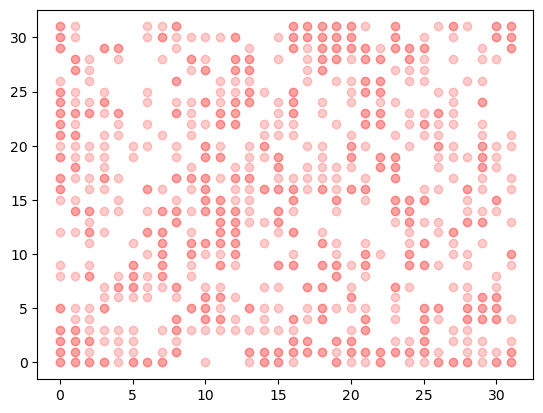

In [175]:
plt.scatter(xred,yred,alpha=0.2,c='r')

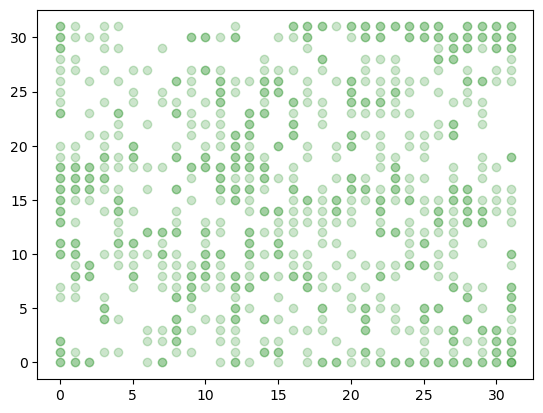

In [176]:
plt.scatter(xgreen,ygreen,alpha=0.2,c='g')

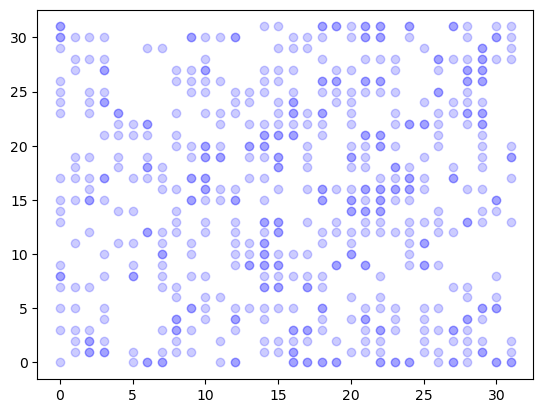

In [177]:
plt.scatter(xblue,yblue,alpha=0.2,c='b')

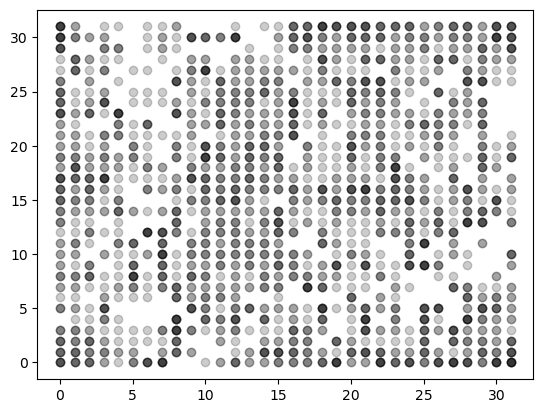

In [182]:
plt.scatter(x,y,alpha=0.2,c='black')

In [186]:
resultsl1 = lgrcv1.coef_
resultsl1 = resultsl1.reshape([32,32,3])
x = []
y = []

xred = []
yred = []

xgreen = []
ygreen = []

xblue = []
yblue = []

weight = [0.005,0.01,0.05,0.1]

for w in range(len(weight)):
    for rgb in range(3):
        for i in range(32):
            for j in range(32):
                if abs(resultsl1[i,j,rgb]) > weight[w]:
                    if rgb == 0:
                        xred.append(i);
                        yred.append(j);
                    if rgb == 1:
                        xgreen.append(i);
                        ygreen.append(j);
                    if rgb == 2:
                        xblue.append(i);
                        yblue.append(j);

x = xred + xgreen + xblue;
y = yred + ygreen + yblue

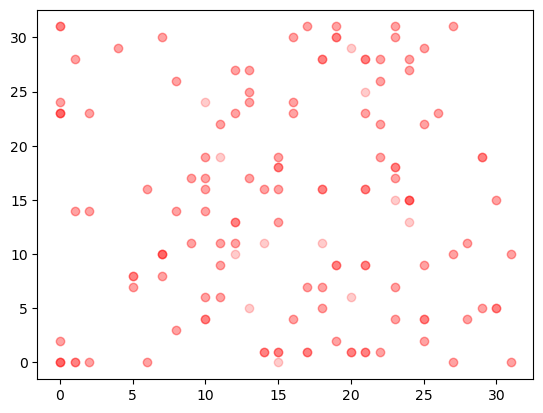

In [187]:
plt.scatter(xred,yred,alpha=0.2,c='r')

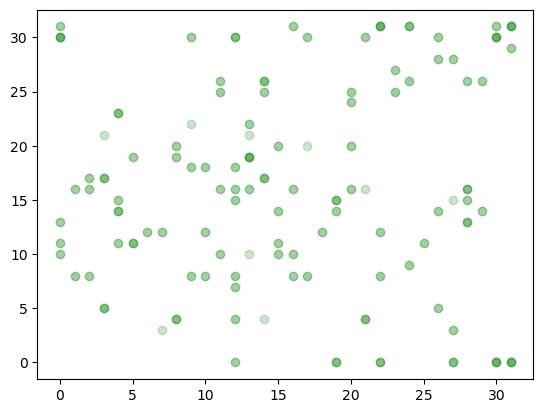

In [188]:
plt.scatter(xgreen,ygreen,alpha=0.2,c='g')

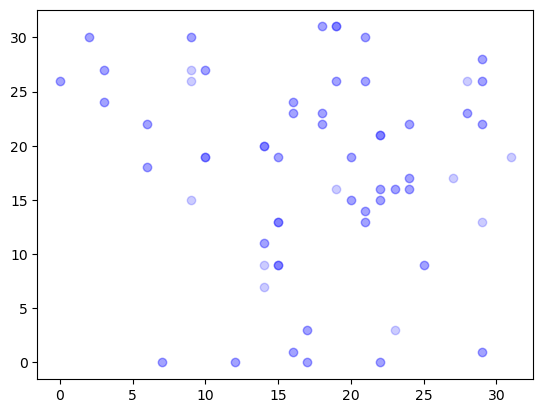

In [189]:
plt.scatter(xblue,yblue,alpha=0.2,c='b')

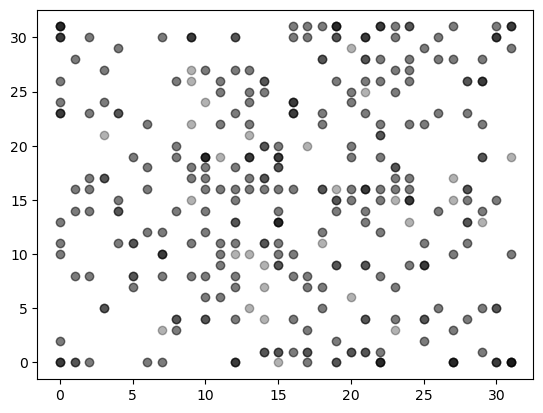

In [194]:
plt.scatter(x,y,alpha=0.3,c='black')